In [399]:
import numpy as np
import math
import scipy.stats
import matplotlib.pyplot as plt

In [400]:
def readExcelSheet1(excelfile):
    from pandas import read_excel
    return (read_excel(excelfile)).values

In [401]:
def readExcelRange(excelfile,sheetname="Sheet1",startrow=1,endrow=1,startcol=1,endcol=1):
    from pandas import read_excel
    values=(read_excel(excelfile, sheetname,header=None)).values;
    return values[startrow-1:endrow,startcol-1:endcol]

In [402]:
def readExcel(excelfile,**args):
    if args:
        data=readExcelRange(excelfile,**args)
    else:
        data=readExcelSheet1(excelfile)
    if data.shape==(1,1):
        return data[0,0]
    elif (data.shape)[0]==1:
        return data[0]
    else:
        return data

In [403]:
def writeExcelData(x,excelfile,sheetname,startrow,startcol):
    from pandas import DataFrame, ExcelWriter
    from openpyxl import load_workbook
    df=DataFrame(x)
    book = load_workbook(excelfile)
    writer = ExcelWriter(excelfile, engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=sheetname,startrow=startrow-1, startcol=startcol-1, header=False, index=False)
    writer.save()
    writer.close()

In [404]:
def getSheetNames(excelfile):
    from pandas import ExcelFile
    return (ExcelFile(excelfile)).sheet_names

In [405]:
excelfile=r"/Users/gholami/Documents/ucsc machine learning/assignment 2/Assignment_2_Data_and_Template.xlsx";

In [406]:
def BF(x,B,hmin,hmax,smin,smax):
    r = (np.round(((B-1)*(x[0]-hmin)/(hmax-hmin)))).astype('int32');
    c = (np.round(((B-1)*(x[1]-smin)/(smax-smin)))).astype('int32');
    return[r,c]

def Build1DHistogramClassifier(X,T,B,xmin,xmax):
    HF=np.zeros(B).astype('int32');
    HM=np.zeros(B).astype('int32');
    for i,x in enumerate(X):
        b = BF(x,B,xmin,xmax)
        if T[i]=='Female':
            HF[b]+=1;
        elif T[i]=='Male':
            HM[b]+=1;
        else:
            print i + x + "error";
            
    return [HF,HM]

In [407]:
def Build2DHistogramClassifier(X,T,B,xmin,xmax):
    HF=np.zeros([B,B]).astype('int32');
    HM=np.zeros([B,B]).astype('int32');
    RC=(np.round(((B-1)*(X-xmin)/(xmax-xmin)))).astype('int32');

    for i,rc in enumerate(RC):
        if T[i]=='Female':
            HF[rc[0],rc[1]]+=1;
        else:
            HM[rc[0],rc[1]]+=1;
            
    return [HF,HM]

In [408]:
def Apply2DHistogramClassifier(queries, HF, HM, xmin, xmax):
    B = np.alen(HF);
    RC=(np.round(((B-1)*(queries-xmin)/(xmax-xmin)))).astype('int32');
    countF = HF[RC[:,0],RC[:,1]];
    countM = HM[RC[:,0],RC[:,1]];
    
    resultlabel = np.full(np.alen(RC),"Indeterminate", dtype=object);
    indicesF = countF > countM;
    indicesM = countM > countF;
    resultlabel[indicesF]="Female";
    resultlabel[indicesM]="Male";
    resultprob = countF*1.0/(countF+countM);
    return resultlabel, resultprob

    
    
    

In [409]:
def Build2DBayesianClassifier(X,T):
    muF = np.mean(X[T=='Female'],axis=0);
    muM = np.mean(X[T=='Male'],axis=0);
    sigmaF=np.cov(X[T=='Female'],rowvar=False);
    sigmaM=np.cov(X[T=='Male'],rowvar=False);

    NF = len(T[T=='Female']);
    NM = len(T[T=='Male']);
    return [muF,muM,sigmaF,sigmaM,NF,NM]
    

In [410]:
def pdf(x,mu,sigma):
    from numpy.linalg import det
    d = np.alen(mu)
    dfact1 = (2*np.pi)**d
    dfact2 = det(sigma)
    fact = 1/np.sqrt(dfact1*dfact2)
    xc=x-mu
    isigma=np.linalg.inv(sigma)
    return fact*np.exp(-0.5*np.einsum('ij,jk,ik->i',xc,isigma,xc));

In [411]:
def Apply2DBayesianClassifier(queries,muF,muM,sigmaF,sigmaM,NF,NM):

    countF=NF*pdf(queries,muF,sigmaF)
    countM=NM*pdf(queries,muM,sigmaM)
    resultlabel=np.full(np.alen(queries),"Indeterminate",dtype=object);
    indicesF=countF>countM;
    indicesM=countM>countF;
    resultlabel[indicesF]="Female";
    resultlabel[indicesM]="Male";
    resultprob=countF/(countF+countM);
    return resultlabel, resultprob


Prepare Data

In [412]:
excelfile=r"/Users/gholami/Documents/ucsc machine learning/assignment 2/Assignment_2_Data_and_Template.xlsx";

In [413]:
sheets=getSheetNames(excelfile);sheets

[u'Data',
 u'Female Histogram',
 u'Male Histogram',
 u'Bayesian',
 u'Queries',
 u'Reconstructed Female Histogram',
 u'Reconstructed Male Histogram',
 u'Observations']

In [414]:
data=readExcel(excelfile)
X = np.array(data[:,1:],dtype=float);
T=data[:,0];
X

array([[ 68.  ,  21.5 ],
       [ 71.  ,  23.5 ],
       [ 73.  ,  22.5 ],
       [ 64.  ,  18.  ],
       [ 68.  ,  23.5 ],
       [ 59.  ,  20.  ],
       [ 73.  ,  23.  ],
       [ 75.  ,  24.5 ],
       [ 65.  ,  21.  ],
       [ 69.  ,  20.5 ],
       [ 69.  ,  20.5 ],
       [ 64.  ,  18.5 ],
       [ 67.  ,  21.  ],
       [ 67.  ,  19.5 ],
       [ 69.  ,  22.  ],
       [ 73.  ,  22.  ],
       [ 62.  ,  20.  ],
       [ 69.  ,  22.5 ],
       [ 64.  ,  18.5 ],
       [ 74.  ,  21.5 ],
       [ 73.  ,  24.5 ],
       [ 66.  ,  20.5 ],
       [ 74.  ,  24.5 ],
       [ 73.  ,  21.  ],
       [ 69.  ,  21.  ],
       [ 64.  ,  18.5 ],
       [ 67.  ,  18.  ],
       [ 60.  ,  19.5 ],
       [ 75.  ,  20.5 ],
       [ 64.  ,  21.  ],
       [ 67.  ,  20.  ],
       [ 67.  ,  20.  ],
       [ 66.  ,  19.  ],
       [ 62.  ,  17.  ],
       [ 72.  ,  22.  ],
       [ 71.  ,  22.  ],
       [ 61.  ,  17.5 ],
       [ 63.  ,  19.  ],
       [ 66.  ,  19.  ],
       [ 71.  ,  22.  ],


In [415]:
queries=(readExcel(excelfile,
                  sheetname='Queries',
                  startrow=3,
                  endrow=6,
                  startcol=1,
                  endcol=2)).astype(float);queries

array([[ 69. ,  17.5],
       [ 66. ,  22. ],
       [ 70. ,  21.5],
       [ 69. ,  23.5]])

Histogram Classifier

In [416]:
num = len(data)/2
B = int(round(math.log(num,2))+1); #B=10
xmin = np.amin(X,axis=0);
xmax = np.amax(X,axis=0);

[HF,HM] = Build2DHistogramClassifier(X,T,B,xmin,xmax);
#writeExcelData([hmin,hmax,smin,smax],excelfile,'Female Histogram',1,2)
#writeExcelData([hmin,hmax,smin,smax],excelfile,'Male Histogram',1,2)
#c ="%dx%d"%(B,B)
#writeExcelData([c],excelfile,'Male Histogram',6,2)
#writeExcelData([c],excelfile,'Female Histogram',6,2)
#writeExcelData(HF,excelfile,'Female Histogram',7,2)
#writeExcelData(HM,excelfile,'Male Histogram',7,2)

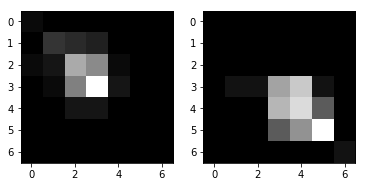

In [417]:
plt.subplot(1,2,1);
plt.imshow(HF,interpolation='None',cmap=plt.get_cmap('gray'));
plt.subplot(1,2,2);
plt.imshow(HM,interpolation='None',cmap=plt.get_cmap('gray'));
plt.show()

In [418]:
[resultHlabel, resultHprob]=Apply2DHistogramClassifier(queries, HF, HM, xmin, xmax)
[resultHlabel, resultHprob]
#writeExcelData(resultHprob,excelfile,'Queries',3,3)

[array(['Indeterminate', 'Male', 'Male', 'Male'], dtype=object),
 array([ 0.5       ,  0.15384615,  0.16666667,  0.        ])]

In [419]:
#writeExcelData([hmin,hmax,smin,smax],excelfile,'Reconstructed Female Histogram',1,2)
#writeExcelData([hmin,hmax,smin,smax],excelfile,'Reconstructed Male Histogram',1,2)
#writeExcelData([c],excelfile,'Reconstructed Female Histogram',6,2)
#writeExcelData([c],excelfile,'Reconstructed Male Histogram',6,2)

With just 50 samples

Bayesian Classifier

In [420]:
[muF,muM,sigmaF,sigmaM,NF,NM]=Build2DBayesianClassifier(X,T)
print(X.shape,T.shape,muF.shape);
print(X,T,muF);
#writeExcelData(np.vstack((muF,muM)),excelfile,'Bayesian',1,3)
#writeExcelData(sigmaF,excelfile,'Bayesian',4,3)
#writeExcelData(sigmaM,excelfile,'Bayesian',6,3)
#writeExcelData([NF],excelfile,'Bayesian',9,3)
#writeExcelData([NM],excelfile,'Bayesian',10,3)

((167, 2), (167,), (2,))
(array([[ 68.  ,  21.5 ],
       [ 71.  ,  23.5 ],
       [ 73.  ,  22.5 ],
       [ 64.  ,  18.  ],
       [ 68.  ,  23.5 ],
       [ 59.  ,  20.  ],
       [ 73.  ,  23.  ],
       [ 75.  ,  24.5 ],
       [ 65.  ,  21.  ],
       [ 69.  ,  20.5 ],
       [ 69.  ,  20.5 ],
       [ 64.  ,  18.5 ],
       [ 67.  ,  21.  ],
       [ 67.  ,  19.5 ],
       [ 69.  ,  22.  ],
       [ 73.  ,  22.  ],
       [ 62.  ,  20.  ],
       [ 69.  ,  22.5 ],
       [ 64.  ,  18.5 ],
       [ 74.  ,  21.5 ],
       [ 73.  ,  24.5 ],
       [ 66.  ,  20.5 ],
       [ 74.  ,  24.5 ],
       [ 73.  ,  21.  ],
       [ 69.  ,  21.  ],
       [ 64.  ,  18.5 ],
       [ 67.  ,  18.  ],
       [ 60.  ,  19.5 ],
       [ 75.  ,  20.5 ],
       [ 64.  ,  21.  ],
       [ 67.  ,  20.  ],
       [ 67.  ,  20.  ],
       [ 66.  ,  19.  ],
       [ 62.  ,  17.  ],
       [ 72.  ,  22.  ],
       [ 71.  ,  22.  ],
       [ 61.  ,  17.5 ],
       [ 63.  ,  19.  ],
       [ 66.  ,  19.  ],

In [350]:
[resultBlabel, resultBprob]=Apply2DBayesianClassifier(queries,muF,muM,sigmaF,sigmaM,NF,NM)

In [351]:
[resultBlabel, resultBprob]
#writeExcelData(resultBprob,excelfile,'Queries',3,4)


[array(['Female', 'Female', 'Male', 'Male'], dtype=object),
 array([ 0.89853626,  0.65557922,  0.19885722,  0.0564518 ])]

Reconstructed Histograms

In [352]:
[htmin, hsmin]=xmin;
[htmax,hsmax]=xmax;
HFrec=np.zeros_like(HF);
HMrec=np.zeros_like(HM);
bA=(htmax-htmin)*(hsmax-hsmin)/((B-1)**2) #each bin area
for r,ht in enumerate(np.linspace(htmin,htmax,B)):   #center of the bin
    for c,hs in enumerate(np.linspace(hsmin,hsmax,B)):
        HFrec[r,c]=(np.round(NF*bA*pdf([[ht,hs]],muF,sigmaF)[0])).astype('int32')
        HMrec[r,c]=(np.round(NM*bA*pdf([[ht,hs]],muM,sigmaM)[0])).astype('int32')


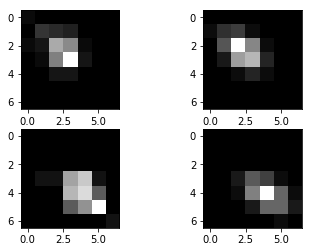

In [353]:
plt.subplot(2,2,1);
plt.imshow(HF,interpolation='None',cmap=plt.get_cmap('gray'));
plt.subplot(2,2,2);
plt.imshow(HFrec,interpolation='None',cmap=plt.get_cmap('gray'));
plt.subplot(2,2,3);
plt.imshow(HM,interpolation='None',cmap=plt.get_cmap('gray'));
plt.subplot(2,2,4);
plt.imshow(HMrec,interpolation='None',cmap=plt.get_cmap('gray'));
plt.show()

In [354]:
[np.sum(H) for H in [HF, HFrec, HM, HMrec]]

[89, 89, 78, 76]

def Cunstruct1DBayesianHistogram(queries,muF,muM,zF,zM,NF,NM):
    w=1;
    countF=np.array([NF*w*pdf(q,muF,zF)for q in queries])
    countM=np.array([NM*w*pdf(q,muM,zM) for q in queries])
    resultlabel=np.full(np.alen(queries),"Indeterminate",dtype=object);
    indicesF=countF>countM;
    indicesM=countM>countF;
    resultlabel[indicesF]="Female";
    resultlabel[indicesM]="Male";
    resultprob=countF/(countF+countM);
    return resultlabel, resultprob
    #return [countF,countM]